In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from gptchem.data import get_hea_phase_data
from gptchem.evaluator import evaluate_classification
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Get the dummy metrics

In [3]:
data = get_hea_phase_data()

In [4]:
estimators = ["uniform", "stratified", "most_frequent"]
results = []
train_sizes = [10, 20, 50, 100, 200]
for i in range(10):
    for estimator in estimators:
        for train_size in train_sizes:
            train, test = train_test_split(
                data,
                train_size=train_size,
                test_size=250,
                stratify=data["phase_binary_encoded"],
                random_state=i,
            )
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train["Alloy"], train["phase_binary_encoded"])
            predictions = classifier.predict(test["Alloy"])
            res = evaluate_classification(test["phase_binary_encoded"], predictions)
            res["train_size"] = train_size
            res["estimator"] = estimator
            results.append(res)

In [5]:
dummy_results = pd.DataFrame(results)

In [6]:
dummy_grouped = (
    dummy_results[["train_size", "estimator", "accuracy", "f1_macro", "f1_micro", "kappa"]]
    .groupby(["estimator", "train_size"])
    .agg(["mean", "std", sem])
)

In [7]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.5020  0.032235  0.010194  0.501471  0.032774   
              20           0.4920  0.036515  0.011547  0.491389  0.036208   
              50           0.4992  0.029382  0.009291  0.499065  0.029276   
              100          0.5012  0.024661  0.007799  0.500418  0.024708   
              200          0.4828  0.028538  0.009024  0.482129  0.028333   
uniform       10           0.5084  0.029960  0.009474  0.507493  0.029749   
              20           0.5092  0.031499  0.009961  0.508883  0.031477   
              50           0.5040  0.032660  0.010328  0.503645  0.032899   
              100          0.5156  0.039797  0.012585  0.514793  0.039594   
              200          0.5012  0.034205  0.010816  0.500893  0.034190   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          1.036418e-02   0.5020  0.032235  0.010194  0.0040   
              20          1.144997e-02   0.4920  0.036515  0.011547 -0.0160   
              50          9.257956e-03   0.4992  0.029382  0.009291 -0.0016   
              100         7.813391e-03   0.5012  0.024661  0.007799  0.0024   
              200         8.959555e-03   0.4828  0.028538  0.009024 -0.0344   
uniform       10          9.407551e-03   0.5084  0.029960  0.009474  0.0168   
              20          9.953940e-03   0.5092  0.031499  0.009961  0.0184   
              50          1.040367e-02   0.5040  0.032660  0.010328  0.0080   
              100         1.252064e-02   0.5156  0.039797  0.012585  0.0312   
              200         1.081193e-02   0.5012  0.034205  0.010816  0.0024   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.064470  0.020387  
              20          0.073030  0.023094  
              50          0.058764  0.018583  
              100         0.049323  0.015597  
              200         0.057075  0.018049  
uniform       10          0.059920  0.018948  
              20          0.062998  0.019922  
              50          0.065320  0.020656  
              100         0.079595  0.025170  
              200         0.068409  0.021633

## Load the results

### Automatminer

In [17]:
automatminer_out = glob("out-baseline/**/*.pkl")

In [25]:
extracted_automatminer_res = []

for out in automatminer_out:
    out = load_pickle(out)
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_automatminer_res.append(res)

In [26]:
extracted_automatminer_res = pd.DataFrame(extracted_automatminer_res)

In [30]:
extracted_automatminer_res_grouped = extracted_automatminer_res.groupby("train_size").agg(["mean", "std", "sem"])

### GPT

In [8]:
all_out = glob("out/**/*.pkl")

In [9]:
all_out = [load_pickle(p) for p in all_out]

In [10]:
extracted_res = []

for out in all_out:
    res = {
        "base_model": out["base_model"],
        "train_size": out["train_size"],
        "test_size": out["test_size"],
        "n_epochs": out["n_epochs"],
        "learning_rate_multiplier": out["learning_rate_multiplier"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_res.append(res)

In [11]:
extracted_res = pd.DataFrame(extracted_res)

In [12]:
extracted_res_grouped = extracted_res.groupby(["train_size"]).agg(["mean", "std", sem])

In [13]:
extracted_res_grouped

test_size           n_epochs           learning_rate_multiplier  \
                mean  std  sem     mean  std  sem                     mean   
train_size                                                                   
10             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
20             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
50             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
100            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
200            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   

                              frac_valid  ...  accuracy  f1_macro            \
            std           sem       mean  ...       sem      mean       std   
train_size                                ...                                 
10          0.0  1.156482e-18        1.0  ...  0.014498  0.884522  0.047488   
20          0.0  1.156482e-18        1.0  ...  0.017266  0.890336  0.056011   
50          0.0  1.156482e-18        1.0  ...  0.010506  0.932225  0.033577   
100         0.0  0.000000e+00        1.0  ...  0.005310  0.960406  0.015974   
200         0.0  1.156482e-18        1.0  ...  0.002696  0.964376  0.008544   

                      f1_micro                         kappa            \
                 sem      mean       std       sem      mean       std   
train_size                                                               
10          0.015017  0.885600  0.045848  0.014498  0.771200  0.091696   
20          0.017712  0.891600  0.054600  0.017266  0.783200  0.109200   
50          0.010618  0.932400  0.033224  0.010506  0.864800  0.066448   
100         0.005325  0.960444  0.015930  0.005310  0.920889  0.031861   
200         0.002702  0.964400  0.008527  0.002696  0.928800  0.017054   

                      
                 sem  
train_size            
10          0.028997  
20          0.034532  
50          0.021013  
100         0.010620  
200         0.005393  

[5 rows x 24 columns]

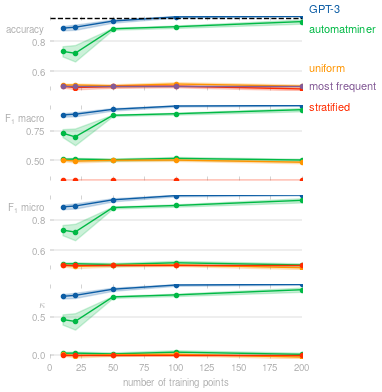

In [34]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # accuracy
    ax[0].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["accuracy"]["mean"],
        marker="o",
        label="GPT-3",
    )
    ax[0].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["accuracy"]["mean"] - extracted_res_grouped["accuracy"]["sem"],
        extracted_res_grouped["accuracy"]["mean"] + extracted_res_grouped["accuracy"]["sem"],
        alpha=0.2,
        color="C0",
    )

    ax[0].plot(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["accuracy"]["mean"],
        marker="o",
        label="automatminer",
    )

    ax[0].fill_between(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["accuracy"]["mean"]
        - extracted_automatminer_res_grouped["accuracy"]["sem"],
        extracted_automatminer_res_grouped["accuracy"]["mean"]
        + extracted_automatminer_res_grouped["accuracy"]["sem"],
        alpha=0.2,
        color="C1",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[0].plot(
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+2}",
        )
        ax[0].fill_between(
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
            - dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
            + dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
            alpha=0.2,
            color=f"C{i+2}",
        )

    # f1 macro
    ax[1].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_macro"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[1].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_macro"]["mean"] - extracted_res_grouped["f1_macro"]["sem"],
        extracted_res_grouped["f1_macro"]["mean"] + extracted_res_grouped["f1_macro"]["sem"],
        alpha=0.2,
        color="C0",
    )

    ax[1].plot(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_macro"]["mean"],
        label="automatminer",
        marker="o",
    )
    ax[1].fill_between(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_macro"]["mean"]
        - extracted_automatminer_res_grouped["f1_macro"]["sem"],
        extracted_automatminer_res_grouped["f1_macro"]["mean"]
        + extracted_automatminer_res_grouped["f1_macro"]["sem"],
        alpha=0.2,
        color="C1",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[1].plot(
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[1].fill_between(
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
            - dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
            + dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    # f1 micro

    ax[2].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_micro"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[2].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_micro"]["mean"] - extracted_res_grouped["f1_micro"]["sem"],
        extracted_res_grouped["f1_micro"]["mean"] + extracted_res_grouped["f1_micro"]["sem"],
        alpha=0.2,
        color="C0",
    )

    ax[2].plot(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_micro"]["mean"],
        label="automatminer",
        marker="o",
    )
    ax[2].fill_between(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_micro"]["mean"]
        - extracted_automatminer_res_grouped["f1_micro"]["sem"],
        extracted_automatminer_res_grouped["f1_micro"]["mean"]
        + extracted_automatminer_res_grouped["f1_micro"]["sem"],
        alpha=0.2,
        color="C1",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[2].plot(
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[2].fill_between(
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
            - dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
            + dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    # kappa
    ax[3].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["kappa"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[3].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["kappa"]["mean"] - extracted_res_grouped["kappa"]["sem"],
        extracted_res_grouped["kappa"]["mean"] + extracted_res_grouped["kappa"]["sem"],
        alpha=0.2,
        color="C0",
    )

    ax[3].plot(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["kappa"]["mean"],
        label="automatminer",
        marker="o",
    )
    ax[3].fill_between(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["kappa"]["mean"]
        - extracted_automatminer_res_grouped["kappa"]["sem"],
        extracted_automatminer_res_grouped["kappa"]["mean"]
        + extracted_automatminer_res_grouped["kappa"]["sem"],
        alpha=0.2,
        color="C1",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[3].plot(
            dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
            dummy_grouped.loc[estimator, :]["kappa"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[3].fill_between(
            dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
            dummy_grouped.loc[estimator, :]["kappa"]["mean"]
            - dummy_grouped.loc[estimator, :]["kappa"]["sem"],
            dummy_grouped.loc[estimator, :]["kappa"]["mean"]
            + dummy_grouped.loc[estimator, :]["kappa"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    ax[0].hlines(0.95, 0, 200, color="k", linestyle="--")

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax[0], fontsize=8)
    fig.savefig("hea_single_vs_multiphase_classifier.pdf", bbox_inches="tight")

In [15]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.5020  0.032235  0.010194  0.501471  0.032774   
              20           0.4920  0.036515  0.011547  0.491389  0.036208   
              50           0.4992  0.029382  0.009291  0.499065  0.029276   
              100          0.5012  0.024661  0.007799  0.500418  0.024708   
              200          0.4828  0.028538  0.009024  0.482129  0.028333   
uniform       10           0.5084  0.029960  0.009474  0.507493  0.029749   
              20           0.5092  0.031499  0.009961  0.508883  0.031477   
              50           0.5040  0.032660  0.010328  0.503645  0.032899   
              100          0.5156  0.039797  0.012585  0.514793  0.039594   
              200          0.5012  0.034205  0.010816  0.500893  0.034190   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          1.036418e-02   0.5020  0.032235  0.010194  0.0040   
              20          1.144997e-02   0.4920  0.036515  0.011547 -0.0160   
              50          9.257956e-03   0.4992  0.029382  0.009291 -0.0016   
              100         7.813391e-03   0.5012  0.024661  0.007799  0.0024   
              200         8.959555e-03   0.4828  0.028538  0.009024 -0.0344   
uniform       10          9.407551e-03   0.5084  0.029960  0.009474  0.0168   
              20          9.953940e-03   0.5092  0.031499  0.009961  0.0184   
              50          1.040367e-02   0.5040  0.032660  0.010328  0.0080   
              100         1.252064e-02   0.5156  0.039797  0.012585  0.0312   
              200         1.081193e-02   0.5012  0.034205  0.010816  0.0024   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.064470  0.020387  
              20          0.073030  0.023094  
              50          0.058764  0.018583  
              100         0.049323  0.015597  
              200         0.057075  0.018049  
uniform       10          0.059920  0.018948  
              20          0.062998  0.019922  
              50          0.065320  0.020656  
              100         0.079595  0.025170  
              200         0.068409  0.021633

In [16]:
dummy_grouped.loc["most_frequent"]

accuracy            f1_macro                    f1_micro            \
               mean  std  sem      mean  std           sem     mean  std  sem   
train_size                                                                      
10              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
20              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
50              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
100             0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
200             0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   

           kappa            
            mean  std  sem  
train_size                  
10           0.0  0.0  0.0  
20           0.0  0.0  0.0  
50           0.0  0.0  0.0  
100          0.0  0.0  0.0  
200          0.0  0.0  0.0